### **HUMAN ACTIVITY RECOGNITION USING SMARTPHONE**

This project aims at building a model predicting six human activities such as Walking, Walking_Upstairs, Walking_Downstairs, Sitting, Standing and Jogging.

The dataset used here is the WISDM LAB Dataset. (https://www.cis.fordham.edu/wisdm/dataset.php)

The Steps Involved here are: i) Exploratory Data Analysis (EDA) ii) Creating Machine Learning Prediction Models on the Expert generated features iii) Creating LSTM based Deep Learning Model on the Raw time series data iv) Comparison of Machine learning models and the Deep Learning Models and finally the conclusion.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/drive/MyDrive/HAR_WISDM/ML/Dataset/WISDM_raw.txt', header = None, names = columns)
df = df.dropna()

In [ ]:
df.head()

user activity       timestamp    x-axis     y-axis        z-axis
0    33  Jogging  49105962326000 -0.694638  12.680544   0.50395286;
1    33  Jogging  49106062271000  5.012288  11.264028   0.95342433;
2    33  Jogging  49106112167000  4.903325  10.882658  -0.08172209;
3    33  Jogging  49106222305000 -0.612916  18.496431    3.0237172;
4    33  Jogging  49106332290000 -1.184970  12.108489     7.205164;

In [ ]:
df['z-axis'] = [(float)(str(x).split(';')[0]) for x in df['z-axis']]
df.head()

user activity       timestamp    x-axis     y-axis    z-axis
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


**EXPLORATORY DATA ANALYSIS**

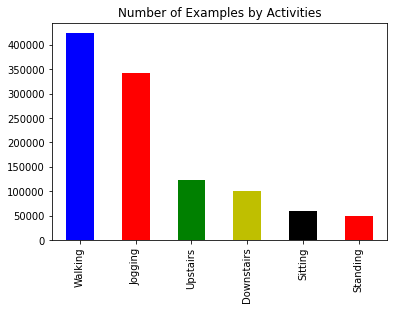

In [ ]:
df['activity'].value_counts().plot(kind='bar', title='Number of Examples by Activities',color=['b','r','g','y','k','r']);

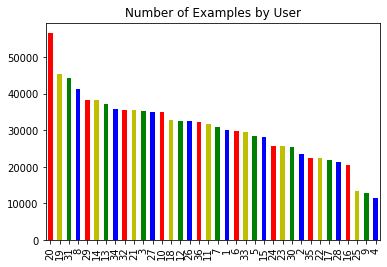

In [ ]:
df['user'].value_counts().plot(kind='bar', title='Number of Examples by User',color=['r','y','g','b']);

Applying dynamic sliding window technique with window_size of 200 data points and an overlap of 10%

In [ ]:
print(df["activity"].unique())

['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


In [ ]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(6, 4), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

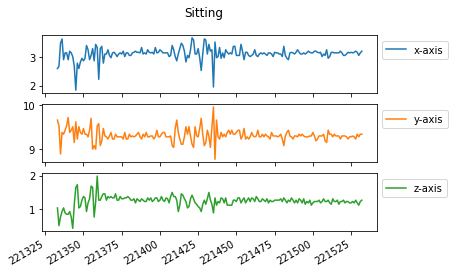

In [ ]:
plot_activity("Sitting", df)

For Sitting Activity, We notice that there is no intersection between the axes, due to the less frequency of the the signals and also when someone is sitting, the sensors tend to be more stable than other activities.

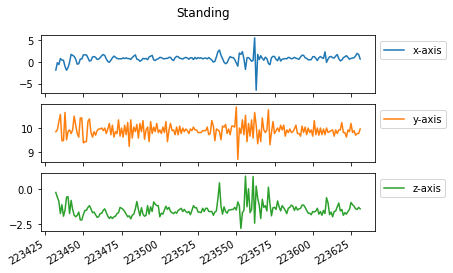

In [ ]:
plot_activity("Standing", df)

The x and z axis are intersecting in standing, that's a good sign to differentiate between standing and sitting, since in both activities, the sensors are tend to be stable, but for standing, we can notice that the x & z axis are more sensitive.

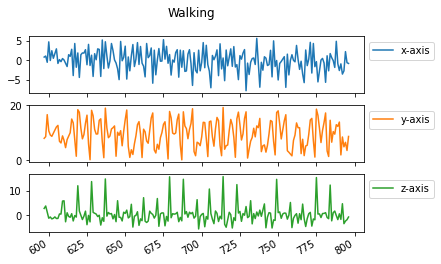

In [ ]:
plot_activity("Walking", df)

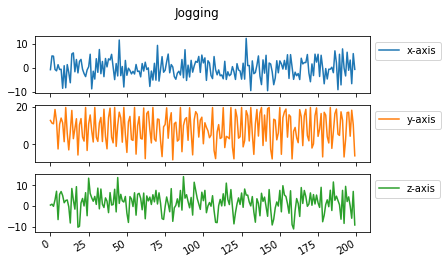

In [ ]:
plot_activity("Jogging", df)

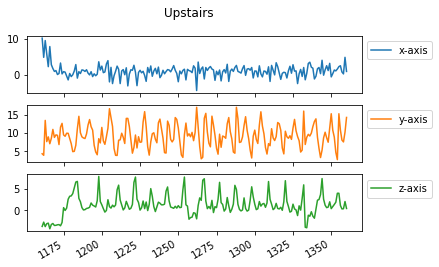

In [ ]:
plot_activity("Upstairs", df)

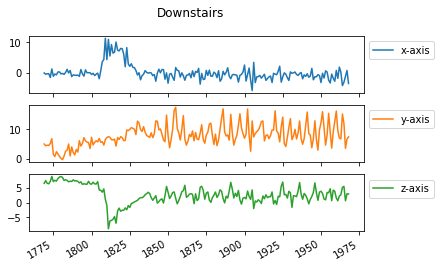

In [ ]:
plot_activity("Downstairs",df)

**Let's check how the values are correlated for some activities.**

In [ ]:
plt.rcParams["figure.figsize"] = (15,7)

In [ ]:
import seaborn as sns
def plot_corr(activity, df):
    corr = df[df["activity"]==activity].corr()
    corr = corr[["x-axis","y-axis","z-axis"]][2:5]
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=100)    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

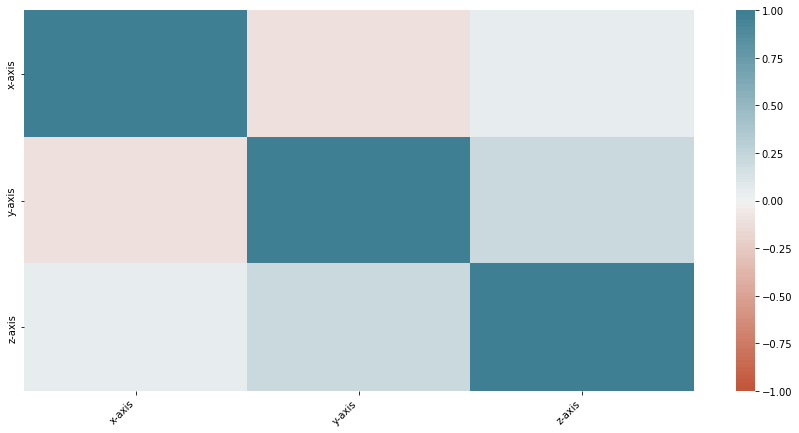

In [ ]:
plot_corr("Walking",df)

The y and x are negativly correlated, and y and z are positivly correlated, while z and x axis are not correlated

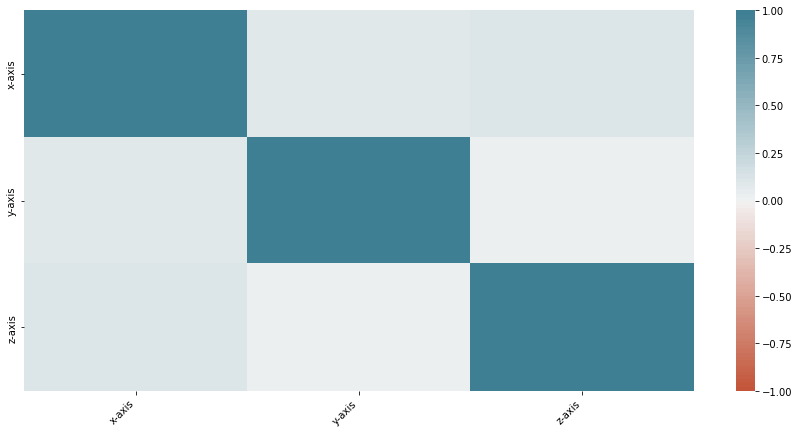

In [ ]:
plot_corr("Jogging",df)

we can notice that z and x axis are not correlated at all, which is a good thing for training our model, also in Jogging activity, the x and y and y and z are positivly correlated.

In [ ]:
TIME_STEPS = 200
N_FEATURES = 3
STEP = 20
trains = []
labels = []
for i in range(0, len(df) - TIME_STEPS, STEP):
    xT = df['x-axis'].values[i: i + TIME_STEPS]
    yT = df['y-axis'].values[i: i + TIME_STEPS]
    zT = df['z-axis'].values[i: i + TIME_STEPS]
    label = stats.mode(df['activity'][i: i + TIME_STEPS])[0][0]
    trains.append([xT, yT, zT])
    labels.append(label)

Checking the dimensions of features and labels

In [ ]:
print(np.asarray(trains).shape)
print(np.asarray(labels).shape)

(54901, 3, 200)
(54901,)


Applying Onehot encoding

In [ ]:
train = np.asarray(trains, dtype= np.float32).reshape(-1, TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

print(labels.shape)

(54901, 6)


Splitting datasets into test and train sets.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
        train, labels, test_size=0.2, random_state=42)

Checking for Null values in test and train sets..... if any null value exists the loss function will return Nan instead of the loss.

In [ ]:
print(np.any(np.isnan(x_train)))
print(np.any(np.isnan(x_test)))

False
False


Preparing LSTM model with 64 hidden units.

In [ ]:
HIDDEN = 64
N_LABELS = 6
def LSTM_model(inputs):
  
  weights = {
      'hidden' : tf.Variable(tf.random_normal([N_FEATURES,HIDDEN])),
      'output' : tf.Variable(tf.random_normal([HIDDEN,N_LABELS]))
  }
  
  bias = {
      'hidden' : tf.Variable(tf.random_normal([HIDDEN],mean=1.0)),
      'output' : tf.Variable(tf.random_normal([N_LABELS]))
  }
  
  INPUT = tf.transpose(inputs,[1,0,2])
  INPUT = tf.reshape(INPUT,[-1,N_FEATURES])
  
  HDN = tf.nn.relu(tf.matmul(INPUT,weights['hidden'])+bias['hidden'])
  HDN = tf.split(HDN,TIME_STEPS,0)
  
  lstm_layers = [tf.contrib.rnn.BasicLSTMCell(HIDDEN,forget_bias=1.0) for _ in range(2)]
  lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)
  
  outputs,_ = tf.contrib.rnn.static_rnn(lstm_layers,HDN,dtype =tf.float32)
  
  last = outputs[-1]
  
  return tf.matmul(last,weights['output'])+bias['output'] 

Creating placeholders promising that we give the inputs later.i.e is in real time

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,TIME_STEPS,N_FEATURES],name='input')
Y = tf.placeholder(tf.float32,[None,N_LABELS])

In [ ]:
y_pred = LSTM_model(X)
y_softmax= tf.nn.softmax(y_pred,name='y')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


loss methods

In [ ]:
L2_loss = 0.0015
l2_regularization = L2_loss * sum(tf.nn.l2_loss(trainable_var) for trainable_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred,labels= Y))+l2_regularization

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Giving optimizer and function for accuracy

In [ ]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_softmax,1),tf.argmax(Y,1)),tf.float32))

Training the model with 50 epochs and the for optimizing we use batch size as 1024 as the RAM runs out if the dataset is large.

In [ ]:
EPOCHS = 50
BATCH = 1024
COUNT = len(x_train)

In [ ]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

losses = []
accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(1,EPOCHS+1):
  print('EPOCH NO : ',epoch)
  for start,end in zip(range(0, COUNT, BATCH),
                          range(BATCH, COUNT + 1,BATCH)):
    
    sess.run(optimizer,feed_dict={X:x_train[start:end],Y:y_train[start:end]})
    
  _,valid_acc,valid_loss = sess.run([y_softmax,accuracy,loss],feed_dict={X:x_train,Y:y_train})
  _,test_acc,test_loss = sess.run([y_softmax,accuracy,loss],feed_dict={X:x_test,Y:y_test})
  
  losses.append(valid_loss)
  accuracies.append(valid_acc)
  test_losses.append(test_loss)
  test_accuracies.append(test_acc)
  if epoch==1 or epoch%10==0:
    
    print('EPOCH NO : ',epoch)
    print('val_acc : ',valid_acc,' val_loss',valid_loss)
    print('test_acc : ',test_acc,' test_loss',test_loss)

EPOCH NO :  1
EPOCH NO :  1
val_acc :  0.8076275  val_loss 1.2852349
test_acc :  0.8031145  test_loss 1.2878201
EPOCH NO :  2
EPOCH NO :  3
EPOCH NO :  4
EPOCH NO :  5
EPOCH NO :  6
EPOCH NO :  7
EPOCH NO :  8
EPOCH NO :  9
EPOCH NO :  10
EPOCH NO :  10
val_acc :  0.9435565  val_loss 0.61362475
test_acc :  0.93944085  test_loss 0.6281043
EPOCH NO :  11
EPOCH NO :  12
EPOCH NO :  13
EPOCH NO :  14
EPOCH NO :  15
EPOCH NO :  16
EPOCH NO :  17
EPOCH NO :  18
EPOCH NO :  19
EPOCH NO :  20
EPOCH NO :  20
val_acc :  0.9690574  val_loss 0.39644817
test_acc :  0.9628449  test_loss 0.41316277
EPOCH NO :  21
EPOCH NO :  22
EPOCH NO :  23
EPOCH NO :  24
EPOCH NO :  25
EPOCH NO :  26
EPOCH NO :  27
EPOCH NO :  28
EPOCH NO :  29
EPOCH NO :  30
EPOCH NO :  30
val_acc :  0.97090167  val_loss 0.3122177
test_acc :  0.9634824  test_loss 0.3300277
EPOCH NO :  31
EPOCH NO :  32
EPOCH NO :  33
EPOCH NO :  34
EPOCH NO :  35
EPOCH NO :  36
EPOCH NO :  37
EPOCH NO :  38
EPOCH NO :  39
EPOCH NO :  40
EPOCH NO 

Saving the session in ckpt file

In [ ]:
tf.train.write_graph(sess.graph_def,'/content/drive/MyDrive/HAR_WISDM','har.pbtxt')
saver.save(sess,save_path='/content/drive/MyDrive/HAR_WISDM/har.ckpt')

'/content/drive/MyDrive/HAR_WISDM/har.ckpt'

Frezzing the graph : to make Pretrained model.

In [ ]:
from tensorflow.python.tools import freeze_graph

In [ ]:
freeze_graph.freeze_graph('/content/drive/MyDrive/HAR_WISDM/har.pbtxt',input_binary=False,input_saver="",input_checkpoint='/content/drive/MyDrive/HAR_WISDM/har.ckpt',output_node_names='y',restore_op_name='save/restore_all',filename_tensor_name='save/Const:0',output_graph='freeze_model.pb',clear_devices=True,initializer_nodes="")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/HAR_WISDM/har.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 200
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "Variable"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 64
          }
        }
        tensor_content: "W\033Q\276\327/\"?\352}\201\276\n\300\n=\270|\351\276\326%\222\276Z\234\361>:\227\221=\253c\314?\245!\r\2774\265 =\\\242d>X\2721\277\275\376/\277;\240\035>\tu\177\277o\317O>\212\rS\274\017W{>He,\275\322\252\235?\014U\236?g\230w\276d$O<\3125\311?\302\242\265\276Ay\320\276\205\\\264>\340\201/\276&k\'\277\305+\217\275\202|\023\277\2149\301\276\211